In [ ]:
import torch

DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

In [ ]:
from maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    # antibiotics= ['Ciprofloxacin', 'Ceftriaxone', "Cefepime", "Piperacillin-Tazobactam", "Tobramycin"]
    label_includes_species=True
)

driams.loading_type = "memory"

train_size = int(0.8 * len(driams))
test_size = len(driams) - train_size

gen = torch.Generator()

train_dataset, test_dataset = torch.utils.data.random_split(driams, [train_size, test_size], generator= gen.manual_seed(SEED))

driams

/home/jan/Uni/master/src/maldi2resistance/data/driams.py:72: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  self.__meta[key] = pd.read_csv(root_dir / f"{site}/id/{year}/{year}_clean.csv")


Loading Spectra into Memory:   0%|          | 0/55780 [00:00<?, ?it/s]

Antibiotic:,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,Clarithromycin,Clindamycin,Colistin,Cotrimoxazole,Ertapenem,Erythromycin,Fosfomycin,Fosfomycin-Trometamol,Fusidic acid,Gentamicin,Imipenem,Levofloxacin,Meropenem,Mupirocin,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
Number resistant:,1068,13366,8578,21966,628,618,4223,7383,2338,3470,8659,5855,9338,310,4381,2874,7405,427,5468,2303,1326,3620,3481,7560,4217,5194,570,1271,1205,5537,12431,7616,486,580,244,3534,1707,227
Number susceptible:,20941,24992,4194,4905,456,457,5813,31567,4382,24566,28464,8368,36822,1262,9841,15784,24590,21740,9044,10184,4803,8498,22662,31717,17989,27228,4656,3603,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
Number data points:,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,37123,14223,46160,1572,14222,18658,31995,22167,14512,12487,6129,12118,26143,39277,22206,32422,5226,4874,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
driams.label_stats

,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin,Ampicillin-Amoxicillin,Aztreonam,Benzylpenicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,...,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Polymyxin B,Rifampicin,Teicoplanin,Tetracycline,Tobramycin,Vancomycin
positive,1068,13366,8578,21966,628,618,4223,7383,2338,3470,...,1205,5537,12431,7616,486,580,244,3534,1707,227
negative,20941,24992,4194,4905,456,457,5813,31567,4382,24566,...,7031,7740,4286,31308,2305,14964,8486,10376,16809,20540
n_sum,22009,38358,12772,26871,1084,1075,10036,38950,6720,28036,...,8236,13277,16717,38924,2791,15544,8730,13910,18516,20767


In [ ]:
len(driams.selected_antibiotics)

38

In [ ]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=True)
test_features, test_labels, test_species = next(iter(test_loader))

In [ ]:
model = torch.jit.load('model.pt')
model.eval()

RecursiveScriptModule(
  original_name=Model
  (Encoder): RecursiveScriptModule(
    original_name=Encoder
    (input): RecursiveScriptModule(original_name=Linear)
    (layer_1): RecursiveScriptModule(original_name=Linear)
    (layer_2): RecursiveScriptModule(original_name=Linear)
    (LeakyReLU): RecursiveScriptModule(original_name=LeakyReLU)
  )
  (Decoder): RecursiveScriptModule(
    original_name=Decoder
    (input): RecursiveScriptModule(original_name=Linear)
    (layer_1): RecursiveScriptModule(original_name=Linear)
    (layer_2): RecursiveScriptModule(original_name=Linear)
    (layer_3): RecursiveScriptModule(original_name=Linear)
    (LeakyReLU): RecursiveScriptModule(original_name=LeakyReLU)
  )
)

In [ ]:
model = model.to(DEVICE)

test_features = test_features.view(test_size, 18000)
test_features = test_features.to(DEVICE)

test_labels = test_labels.view(test_size, len(driams.selected_antibiotics))
test_labels = test_labels.to(DEVICE)

In [ ]:
latent, output, out_species = model(test_features)

In [ ]:
len(driams.selected_antibiotics)

38

In [ ]:
output.shape

torch.Size([11156, 38])

(0.8965824842453003, 0.8783259595695295)


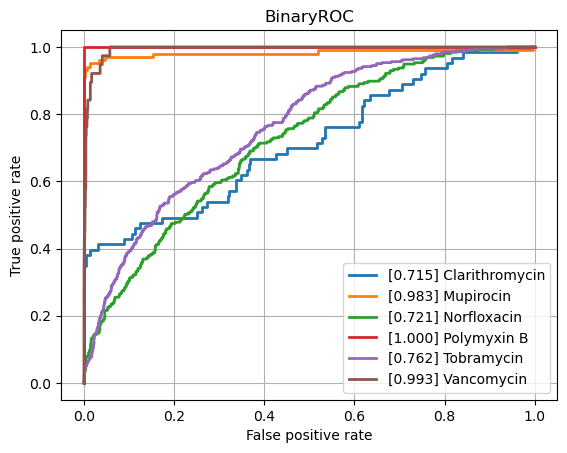

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,test_labels,driams.selected_antibiotics, create_csv="./ROC_results.csv"))
fig_, ax_ = ml_roc()

plt.savefig("./ROC_results.png" , transparent=True, format= "png", bbox_inches = "tight")
plt.show()

(0.7968406081199646, 0.7047613831727129)


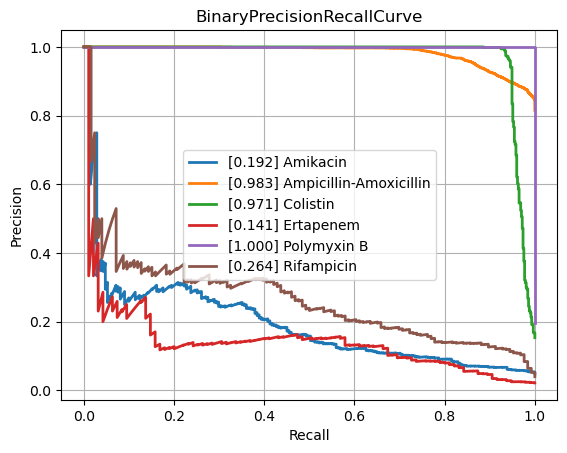

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,test_labels,driams.selected_antibiotics, create_csv="./PR_results.csv"))

fig_, ax_ = ml_pr()

plt.savefig("./PR_results.png" , transparent=True, format= "png", bbox_inches = "tight")
plt.show()

In [ ]:
#test_features= test_features[1:,:]
#test_labels= test_labels[1:,:]

In [ ]:
split1,split2 = torch.chunk(test_features, 2)
combined =torch.add(split1 , split2)
combined_features = torch.div(combined, 2)

In [ ]:
split1,split2 = torch.chunk(test_labels, 2)
combined =torch.add(split1 , split2)
combined_labels = torch.div(combined, 2)
combined_labels[combined_labels == 0.5] =1

In [ ]:
latent, output = model(combined_features)

(0.7028185541138929, 0.7496914863586426)


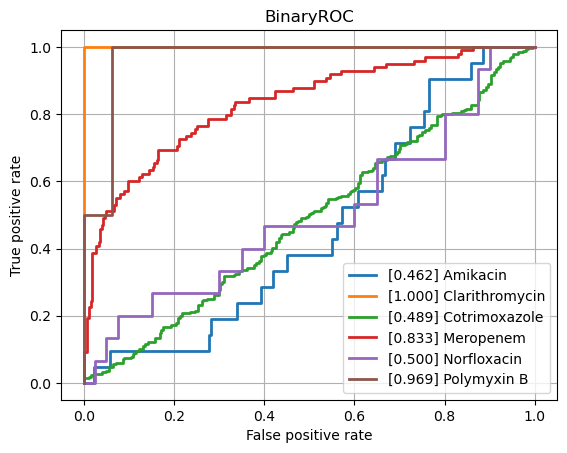

In [ ]:
from maldi2resistance.metric.ROC import MultiLabelRocNan
import matplotlib.pyplot as plt

ml_roc = MultiLabelRocNan()
print(ml_roc.compute(output,combined_labels,driams.selected_antibiotics))
fig_, ax_ = ml_roc()

plt.show()

(0.6096600601997446, 0.6575345993041992)


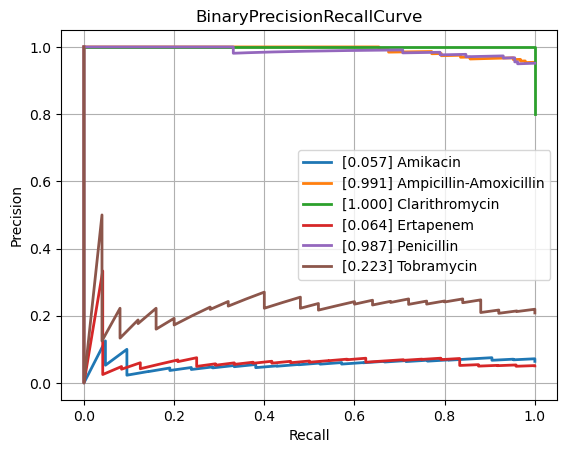

In [ ]:
from maldi2resistance.metric.PrecisionRecall import MultiLabelPRNan
import matplotlib.pyplot as plt

ml_pr = MultiLabelPRNan()
print(ml_pr.compute(output,combined_labels,driams.selected_antibiotics, create_csv="./combined_results.csv"))

fig_, ax_ = ml_pr()

plt.show()

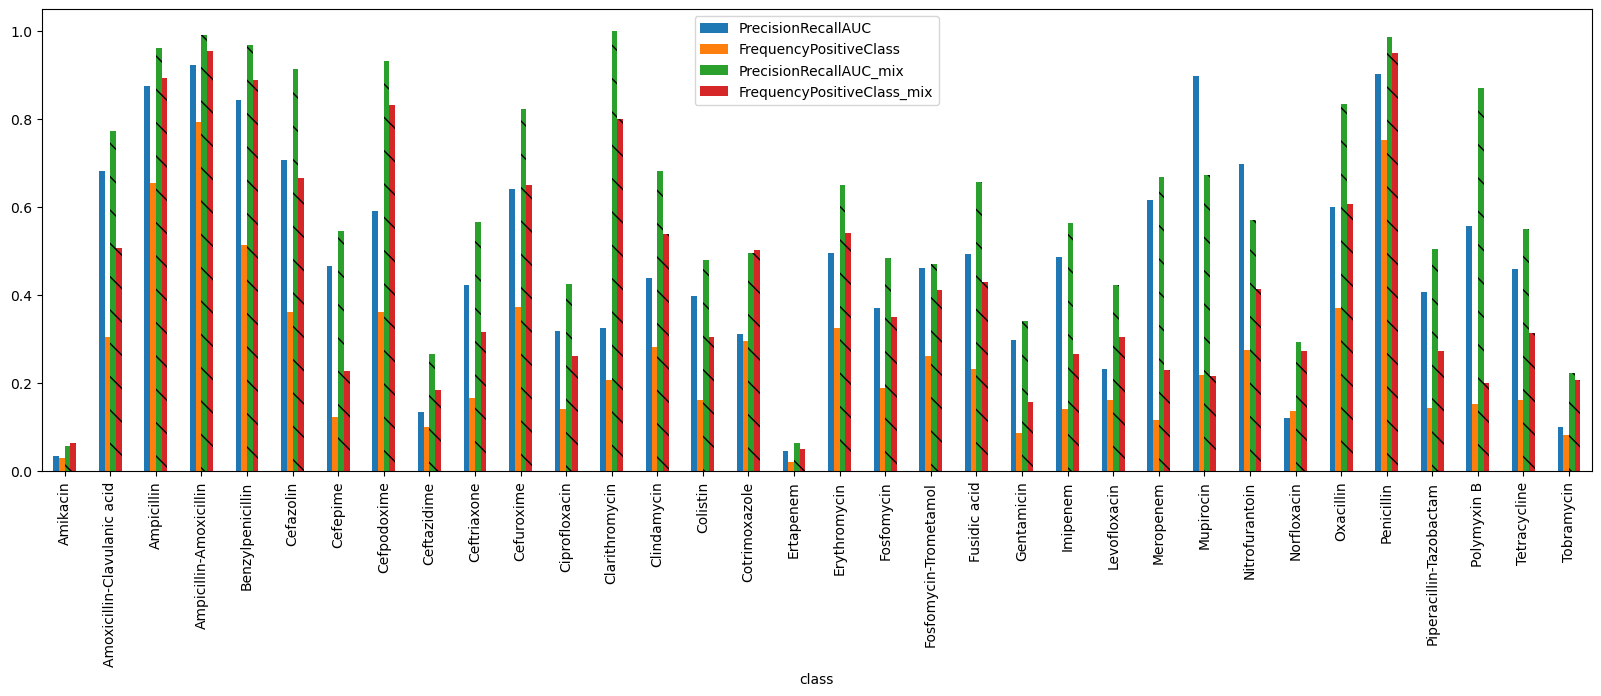

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

mpl.style.use("default")

result = pd.read_csv('./results.csv')
mix_result = pd.read_csv('./combined_results.csv')

combined = pd.merge(result, mix_result, on='class', how='outer', suffixes=('', '_mix'))
combined.set_index("class", inplace=True)

ax = combined.plot.bar(figsize=(20,6))
ax.set_facecolor("none")

for bar in ax.containers:
    if bar.get_label() in ["PrecisionRecallAUC_mix", "FrequencyPositiveClass_mix"]:
        plt.setp(bar, hatch= "\\")

path = Path("/home/jan/Uni/master/data/created_figures/ArtificialData/FeedForward/PrecisionRecall.png")
plt.savefig(path, transparent=True, format= "png", bbox_inches = "tight")
plt.show()